<a href="https://colab.research.google.com/github/LuFernandez/imagaynes/blob/master/analisis_scripts/rep_imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Scripts y representación de imágenes

---



Ezequiel Vijande

Lucero Guadalupe Fernandez

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy import signal

In [2]:
!wget https://raw.githubusercontent.com/lufernandez/imagaynes/master/analisis_scripts/barbara.gif

clear_output()

##ex1

In [7]:
def ApplyUnsharp(img, k_size=3):
  kernel = np.array( [ 
      [-0.1667,   -0.6667,   -0.1667],
      [-0.6667,    4.3333,   -0.6667],
      [-0.1667,   -0.6667,   -0.1667]])
  return cv2.filter2D(img,-1,kernel)


def MakeSubplot(img,fig,row,column,index,title):
  fig.add_subplot(row,column,index)
  plt.title(title)
  plt.axis('off')
  plt.imshow(img,cmap='gray', vmin=0)

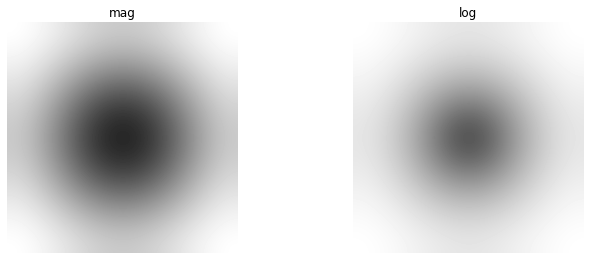

In [32]:
N=256;
big=np.zeros((N,N));       #make a big image
big[N//2][N//2]=1;     #unit impulse

h1 = ApplyUnsharp(big)
S = np.fft.fft2(h1);       #Spectrum
SM=abs(S);          #%Modulo


fig_1 = plt.figure(figsize =(8,8))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.5, wspace = 0.5)

mag=np.fft.fftshift(SM/np.max(np.max(SM)))
MakeSubplot(mag,fig_1,2,2,1, 'mag')

IMd = np.log(1+abs(SM));
log = np.fft.fftshift(IMd/np.max(np.max(IMd)))
MakeSubplot(log,fig_1,2,2,2, 'log')

En primer lugar se crea un filtro pasaaltos. 

A continuación se crea una imagen con un 1 en el (0, 0); una delta, y se convoluciona con el filtro. Al convolucionar la delta con el filtro, éste queda centrado en la imagen de 256x256.

Se calcula la fft de la convolución y se toma su módulo. Luego, se normaliza dividiendo por el máximo de los valores de la fft. La función fftshift(X), swapea el primer cuadrante de X con el tercero, y el segundo con el cuarto, como si invirtiera desde el centro hacia fuera los valores, quedando los valores aumentando hacia y en los bordes; y los valores menores en el centro. Luego se grafican lineal y logarítmicamente. En resumen, lo que se obtiene es la representación en una imagen monocromática de la respuesta en frecuencia del pasaaltos definido al principio. Al aplicar este tipo de filtro sobre una imagen, lo que se obtendría es un efecto de enfoque o sharpen.